<a href="https://colab.research.google.com/github/roshkjr/DeepLearning/blob/main/fashion_mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
from torch import nn
import numpy as np

import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

# Training using only PyTorch

## Get data statistics

In [41]:
transforms = v2.Compose([v2.ToImage(), 
                         v2.ToDtype(torch.float32, scale=True),
                         ])

train_data = datasets.FashionMNIST(
   root="FashionMNIST",
   train = True,
   download = False,
   transform = transforms,
   target_transform = None
)

In [42]:
def get_mean_std(dl: DataLoader):
    """
    Calculates mean and std deviation per channel
    of an image converted to a tensor
    """

    ch_mean, ch_squared_mean, num_batches = 0,0,0
    for data, _ in dl:
        ch_mean += torch.mean(data, dim=(0,2,3)) # tensor dimensions [N, C, H, W]
        ch_squared_mean += torch.mean(data**2, dim=(0,2,3))
        num_batches +=1

    ch_mean = ch_mean/num_batches # average of the total batches
    ch_std = torch.sqrt(ch_squared_mean/num_batches - (ch_mean**2)) 

    return (ch_mean, ch_std)

In [43]:
BATCH_SIZE = 500

train_data_loader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

In [44]:
(ch_mean, ch_std) = get_mean_std(train_data_loader)

In [45]:
(ch_mean, ch_std)

(tensor([0.2860]), tensor([0.3530]))

In [46]:
transforms = v2.Compose([v2.ToImage(), 
                         v2.ToDtype(torch.float32, scale=True),
                         v2.Normalize(mean=[ch_mean], std=[ch_std])
                         ])

train_data = datasets.FashionMNIST(
   root="FashionMNIST",
   train = True,
   download = False,
   transform = transforms,
   target_transform = None
)

BATCH_SIZE = 500

train_data_loader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

In [ ]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [60]:
image, label = train_data[0][0], train_data[0][1]

In [61]:
image.shape

torch.Size([1, 28, 28])

In [14]:
train_data.classes[label]

'Ankle boot'

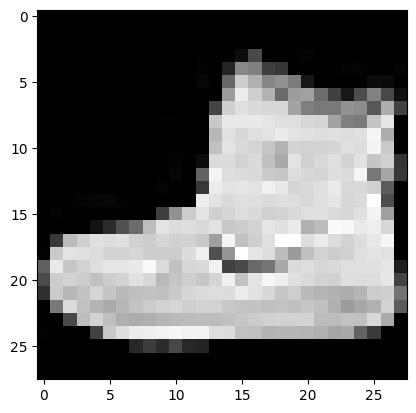

In [9]:
plt.imshow(image.squeeze(), cmap="grey")

In [18]:
class_count = {i: 0 for i in range(10)}
for _, y in train_data_loader:
    for lbl in y:
        class_count[lbl.item()] += 1

In [19]:
class_count

{0: 6000,
 1: 6000,
 2: 6000,
 3: 6000,
 4: 6000,
 5: 6000,
 6: 6000,
 7: 6000,
 8: 6000,
 9: 6000}

In [47]:
test_data = datasets.FashionMNIST(
    root = "FashionMNIST",
    train = False,
    download = False,
    transform = transforms,
    target_transform = None
)

In [48]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)

In [24]:
train_data.targets[:5]

tensor([9, 0, 0, 3, 0])

In [49]:
train_data_mini_indices, test_data_mini_indices = train_test_split(np.arange(len(train_data)), train_size = 0.1, random_state=32, shuffle=True, stratify=train_data.targets)
train_data_mini = Subset(train_data, indices=train_data_mini_indices)

In [49]:
# BATCH_SIZE = 500

# train_data_loader = DataLoader(
#     train_data_mini,
#     batch_size = BATCH_SIZE,
#     shuffle=True
# )

test_data_loader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle=False
)

In [27]:
class_count = {i: 0 for i in range(10)}
for _, y in train_data_loader:
    for lbl in y:
        class_count[lbl.item()] += 1

In [28]:
class_count

{0: 600,
 1: 600,
 2: 600,
 3: 600,
 4: 600,
 5: 600,
 6: 600,
 7: 600,
 8: 600,
 9: 600}

In [29]:
len(train_data_loader)

188

In [30]:
len(train_data_mini)

6000

In [35]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [36]:
def train_step(model, loss_fn, optimizer, device, data_loader, accuracy_fn):

  model.to(device)
  model.train()
  train_loss, batch_correct, batch_size = 0, 0, 0

  for (X,y) in data_loader:
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item() * y.size(0) ## Normalising with respect to the batch size
    batch_correct += torch.eq(y,y_pred.argmax(dim=1)).sum().item()
    batch_size += y.size(0)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= batch_size
  train_accuracy = batch_correct/batch_size

  return (train_loss, train_accuracy)



In [41]:
def test_step(model, data_loader, accuracy_fn):

  model.eval()
  batch_correct, batch_size = 0, 0
  with torch.inference_mode():
    for (X,y) in data_loader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      batch_correct += torch.eq(y,y_pred.argmax(dim=1)).sum().item()
      batch_size += y.size(0)


    test_accuracy = batch_correct/batch_size


  return test_accuracy




In [40]:
class BaseModel(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_dim),
        nn.Linear(hidden_dim, output_dim),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    return self.block(x)


In [37]:
def train_model(model,
                loss_fn,
                epochs,
                train_data_loader,
                test_data_loader,
                optimizer,
                device,
                accuracy_fn,
                writer):
  for epoch in range(epochs):
    train_loss, train_accuracy = train_step(model, loss_fn, optimizer, device, train_data_loader, accuracy_fn)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}%")
    # writer.add_scalar("train_loss",
    #                   train_loss,
    #                   epoch)
    # writer.add_scalar("train_accuracy",
    #                   train_accuracy,
    #                   epoch)
    test_accuracy = test_step(model, test_data_loader, accuracy_fn)
    print(f"Epoch: {epoch} | Test accuracy: {test_accuracy:.2f}%")
    # writer.add_scalar("test_accuracy",
    #                   test_accuracy,
    #                   epoch)


In [34]:
train_data_mini[0][0].shape

torch.Size([1, 28, 28])

In [76]:
28*28

784

In [52]:
loss_fn = nn.CrossEntropyLoss()
#accuracy_fn = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)

In [42]:
model_0 = BaseModel(784, 500, 10)
EPOCHS = 10
LR = 3e-4
model_0_optimizer = torch.optim.Adam(model_0.parameters(), lr = LR)
writer = SummaryWriter(f"fashion_mnist/base_model")
train_model(model_0,loss_fn, EPOCHS,train_data_loader, test_data_loader, model_0_optimizer, device, accuracy_fn, writer)

Epoch: 0 | Train loss: 1.73924 | Train accuracy: 0.76%
Epoch: 0 | Test accuracy: 0.81%
Epoch: 1 | Train loss: 1.65406 | Train accuracy: 0.83%
Epoch: 1 | Test accuracy: 0.82%
Epoch: 2 | Train loss: 1.63325 | Train accuracy: 0.85%
Epoch: 2 | Test accuracy: 0.82%
Epoch: 3 | Train loss: 1.62523 | Train accuracy: 0.85%
Epoch: 3 | Test accuracy: 0.82%
Epoch: 4 | Train loss: 1.61168 | Train accuracy: 0.86%
Epoch: 4 | Test accuracy: 0.83%
Epoch: 5 | Train loss: 1.60897 | Train accuracy: 0.86%
Epoch: 5 | Test accuracy: 0.84%
Epoch: 6 | Train loss: 1.59753 | Train accuracy: 0.88%
Epoch: 6 | Test accuracy: 0.83%
Epoch: 7 | Train loss: 1.59584 | Train accuracy: 0.88%
Epoch: 7 | Test accuracy: 0.84%
Epoch: 8 | Train loss: 1.58790 | Train accuracy: 0.89%
Epoch: 8 | Test accuracy: 0.83%
Epoch: 9 | Train loss: 1.58376 | Train accuracy: 0.89%
Epoch: 9 | Test accuracy: 0.82%


In [23]:
28/2

14.0

In [26]:
4*14*14

784

In [43]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 'same'),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 128, 3, 1, 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(128*7*7, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )
    
    def forward(self, x):
        return self.net(x)

In [51]:
model_1 = simpleCNN()
EPOCHS = 10
LR = 1e-4
model_1_optimizer = torch.optim.Adam(model_1.parameters(), lr = LR)
writer = SummaryWriter(f"fashion_mnist/simple_cnn_model")
train_model(model_1,loss_fn, EPOCHS,train_data_loader, test_data_loader, model_1_optimizer, device, accuracy_fn, writer)

Epoch: 0 | Train loss: 2.07806 | Train accuracy: 0.46%
Epoch: 0 | Test accuracy: 0.59%
Epoch: 1 | Train loss: 1.20013 | Train accuracy: 0.65%
Epoch: 1 | Test accuracy: 0.67%
Epoch: 2 | Train loss: 0.81563 | Train accuracy: 0.70%
Epoch: 2 | Test accuracy: 0.71%
Epoch: 3 | Train loss: 0.73220 | Train accuracy: 0.73%
Epoch: 3 | Test accuracy: 0.74%
Epoch: 4 | Train loss: 0.65776 | Train accuracy: 0.76%
Epoch: 4 | Test accuracy: 0.75%
Epoch: 5 | Train loss: 0.61280 | Train accuracy: 0.78%
Epoch: 5 | Test accuracy: 0.77%
Epoch: 6 | Train loss: 0.58587 | Train accuracy: 0.79%
Epoch: 6 | Test accuracy: 0.79%
Epoch: 7 | Train loss: 0.55365 | Train accuracy: 0.80%
Epoch: 7 | Test accuracy: 0.80%
Epoch: 8 | Train loss: 0.53009 | Train accuracy: 0.81%
Epoch: 8 | Test accuracy: 0.80%
Epoch: 9 | Train loss: 0.50769 | Train accuracy: 0.82%
Epoch: 9 | Test accuracy: 0.81%


# Training using FastAI 

In [50]:
from functools import partial
from fastai.data.core import DataLoaders
from fastai.optimizer import OptimWrapper
from fastai.learner import Learner
from fastai.metrics import accuracy
import fastai.callback.schedule

In [51]:
dls = DataLoaders(train_data_loader, test_data_loader)

In [14]:
opt_func = partial(OptimWrapper, opt=torch.optim.Adam)

In [31]:
fast_model_0 = BaseModel(784, 500, 10)
learn_0 = Learner(dls, fast_model_0, loss_func=loss_fn, opt_func=opt_func, metrics=accuracy)

SuggestedLRs(valley=0.0020892962347716093)

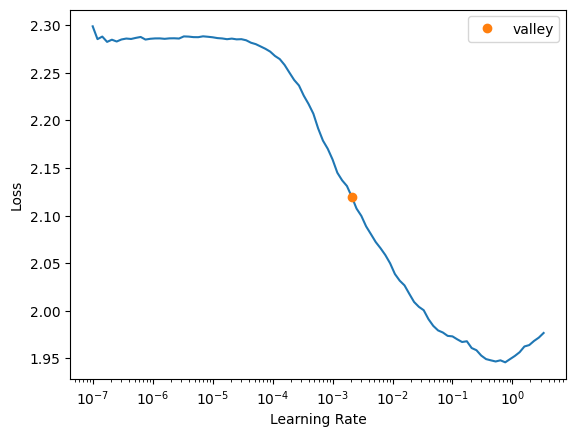

In [28]:
learn_0.lr_find()

In [30]:
learn_0.fit_one_cycle(n_epoch=10, lr_max=0.002)

epoch,train_loss,valid_loss,accuracy,time
0,1.717300,1.713267,0.765000,00:03
1,1.671599,1.700495,0.775100,00:03
2,1.656250,1.665387,0.802800,00:03
3,1.637391,1.646345,0.818200,00:03
4,1.635390,1.657821,0.805600,00:03
5,1.620311,1.653104,0.812200,00:03
6,1.601889,1.639195,0.824900,00:03
7,1.583706,1.635621,0.826900,00:03
8,1.581202,1.628803,0.833700,00:03
9,1.572569,1.627522,0.835700,00:03


In [34]:
LR = 1e-4
learn_0.fit(n_epoch = 10, lr=LR)

epoch,train_loss,valid_loss,accuracy,time
0,1.737244,1.706958,0.791400,00:03
1,1.679076,1.675435,0.811300,00:03
2,1.652655,1.657193,0.824000,00:03
3,1.637162,1.651519,0.828200,00:03
4,1.628315,1.644635,0.832300,00:03
5,1.617290,1.643015,0.832200,00:03
6,1.608787,1.639543,0.837100,00:03
7,1.592122,1.638527,0.833400,00:03
8,1.592530,1.635500,0.838200,00:03
9,1.586209,1.637912,0.837600,00:03


In [57]:
fast_model_1 = simpleCNN()
learn_1 = Learner(dls, fast_model_1, loss_func=loss_fn, opt_func=opt_func, metrics=accuracy)

SuggestedLRs(valley=0.00015848931798245758)

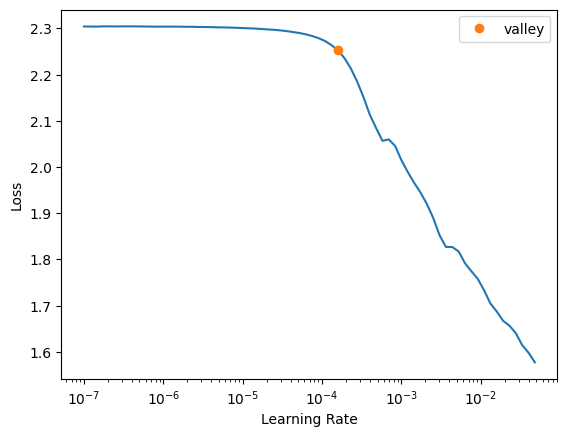

In [56]:
learn_1.lr_find()

In [58]:
learn_1.fit_one_cycle(n_epoch=10, lr_max=0.0001)

epoch,train_loss,valid_loss,accuracy,time
0,2.281749,2.242156,0.409000,00:02
1,2.173529,1.734386,0.608300,00:02
2,1.764807,0.842164,0.686100,00:02
3,1.416556,0.720381,0.739200,00:02
4,1.189460,0.686871,0.757600,00:02
5,1.031755,0.618329,0.769900,00:02
6,0.912493,0.598815,0.776700,00:02
7,0.825467,0.576505,0.791500,00:02
8,0.759086,0.575349,0.789100,00:02
9,0.708745,0.572848,0.791400,00:02


## ResNet

In [16]:
from fastai.vision.all import *
from itertools import chain

In [17]:
def _conv_block(ni, nf, stride):
    layers = nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero)
    )
    return layers

In [33]:
_conv_block(64, 256, 2)

Sequential(
  (0): ConvLayer(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [18]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        self.idconv = noop if ni==nf else ConvLayer(ni,nf,1,act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [62]:
def simpleResNet(ni,nf):
    return nn.Sequential(
            ResBlock(ni, 16, 1),
            ResBlock(16, 32, 2),
            ResBlock(32, 64, 1),
            ResBlock(64, 128, 2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, nf)
           )


In [63]:
simpleResNet(1, 10)

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): ConvLayer(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): ConvLayer(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): ConvLayer(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLaye

In [64]:
simple_resnet_model = simpleResNet(1, 10)
learn_resent_simple = Learner(dls, simple_resnet_model, loss_func=loss_fn, opt_func=opt_func, metrics=accuracy)

SuggestedLRs(valley=0.004365158267319202)

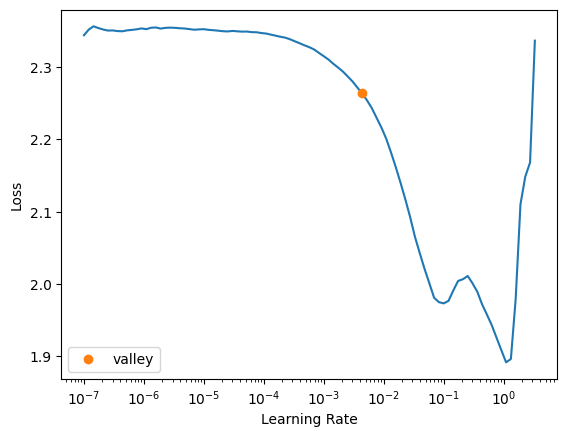

In [65]:
learn_resent_simple.lr_find()

In [66]:
learn_resent_simple.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.289036,2.298723,0.187000,00:06
1,2.167916,2.210421,0.123100,00:06
2,1.961300,2.528672,0.179300,00:06
3,1.711197,2.340309,0.206700,00:07
4,1.484528,2.759611,0.198600,00:06
5,1.291910,2.180828,0.263000,00:06
6,1.138999,0.972628,0.628500,00:06
7,1.016679,0.703993,0.748500,00:06
8,0.921666,0.661785,0.771200,00:06
9,0.847780,0.650578,0.776900,00:06


In [68]:
print(learn_resent_simple.summary())

Sequential (Input shape: 500 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     500 x 16 x 28 x 28  
Conv2d                                    144        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
Conv2d                                    16         True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     500 x 32 x 14 x 14  
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                

In [19]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride=2 if i ==0 else 1)
            for i in range(len(sizes)-1)
        ] + [nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]


In [20]:
class ResNet(Module):
    def __init__(self,ni,nf,body):
        self.ni = ni
        self.nf = nf
        self.block_szs = [64,64,128,256,512]
        self.net = self.make_net(body)

    def make_stage(self, stage_id, n_block):
        stride = 1 if stage_id == 0 else 2
        ch_in,ch_out = self.block_szs[stage_id:stage_id+2]
        return [ResBlock(ch_in if i==0 else ch_out,
                         ch_out,
                         stride if i==0 else 1) 
                for i in range(n_block)]
    
    def make_body(self, body):
        return chain.from_iterable([
            self.make_stage(stage_id, n_block) 
            for stage_id, n_block in enumerate(body)
        ])

    def make_net(self, body):
        stem = _resnet_stem(self.ni,32,32,64)
        body = self.make_body(body)
        return nn.Sequential(
            *stem,
            *body,
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(self.block_szs[-1], self.nf)
        )

    def forward(self, x):
        return self.net(x)

In [21]:
resnet_model = ResNet(1,10,[2,2,2,2])
learn_resent = Learner(dls, resnet_model, loss_func=loss_fn, opt_func=opt_func, metrics=accuracy)

In [22]:
learn_resent.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.571643,0.414549,0.847900,00:17
1,0.348284,0.515218,0.821300,00:13
2,0.273162,0.298900,0.888000,00:13
3,0.225325,0.268219,0.903500,00:13
4,0.185234,0.298313,0.895300,00:13
5,0.145730,0.276414,0.904600,00:13
6,0.110221,0.267017,0.913300,00:13
7,0.065303,0.286807,0.918000,00:13
8,0.034842,0.301903,0.916500,00:13
9,0.021810,0.304323,0.919900,00:13


In [124]:
learn_resent.summary()

ResNet (Input shape: 500 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     500 x 32 x 14 x 14  
Conv2d                                    288        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     500 x 64 x 14 x 14  
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     500 x 64 x 7 x 7    
MaxPool2d                               

In [23]:
vision_learner??

Signature:
vision_learner(
    dls,
    arch,
    normalize=True,
    n_out=None,
    pretrained=True,
    weights=None,
    loss_func=None,
    opt_func=<function Adam at 0x7f4713b9bd80>,
    lr=0.001,
    splitter=None,
    cbs=None,
    metrics=None,
    path=None,
    model_dir='models',
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
    cut=None,
    init=<function kaiming_normal_ at 0x7f474beb65c0>,
    custom_head=None,
    concat_pool=True,
    pool=True,
    lin_ftrs=None,
    ps=0.5,
    first_bn=True,
    bn_final=False,
    lin_first=False,
    y_range=None,
    *,
    n_in=3,
)
Source:   
@delegates(create_vision_model)
def vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, weights=None,
        # learner args
        loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
        model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
        # mod

## Transfer learning

In [25]:
model_meta[resnet18]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
 'weights': 'DEFAULT'}

In [53]:
fmn_learner = vision_learner(dls,
                             resnet18,
                             normalize = False,
                             loss_func=loss_fn,
                             metrics=accuracy,
                             cut = -2,
                             n_in = 1,
                             n_out=10
                            )

The first layer of ResNet stem expects 3 channels. In the case of FashionMNist we have only one channel in the input. Bu the good thing is `vision_learner` supports n_in feature to be specified. And it use the logic [here](https://github.com/fastai/fastai/blob/66a03da8a11cd85188f4c6f063b98c4a209492e8/fastai/vision/learner.py#L33) to deal with the case when there is a mismatch between the number of input channels in the dataloader and pretrained model architecture.

Since in our case n_in = 1, hence the sum of weights from all the channels are used

In [35]:
fmn_learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

SuggestedLRs(valley=0.0014454397605732083)

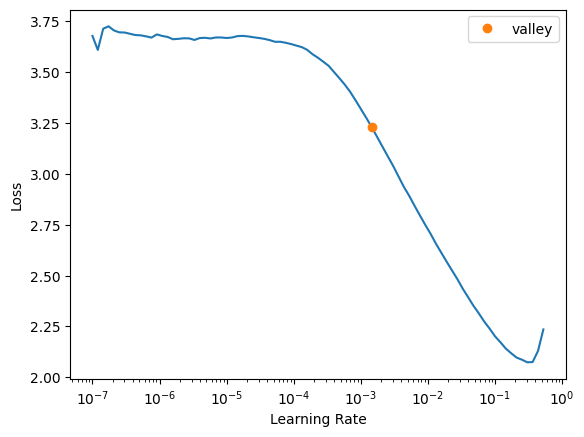

In [36]:
fmn_learner.lr_find()

In [54]:
fmn_learner.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.189814,0.642333,0.780300,00:13
1,0.668574,0.522012,0.813300,00:13
2,0.550892,0.504422,0.820800,00:13


In [55]:
fmn_learner.unfreeze()

SuggestedLRs(valley=0.0003981071640737355)

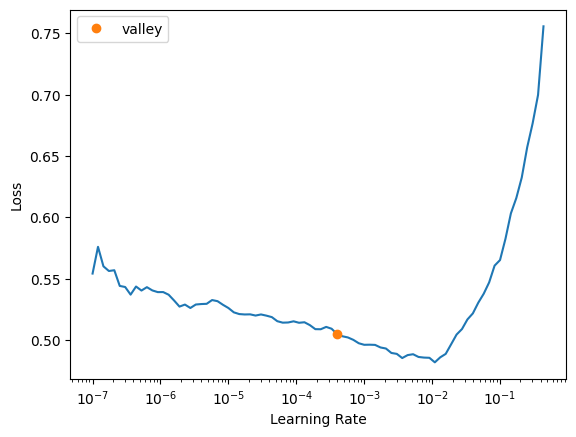

In [56]:
fmn_learner.lr_find()

In [57]:
fmn_learner.fit_one_cycle(6, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.411913,0.348451,0.874900,00:13
1,0.297490,0.287675,0.901800,00:13
2,0.228547,0.255466,0.907200,00:13
3,0.175868,0.244662,0.915000,00:13
4,0.123895,0.246710,0.918700,00:13
5,0.080831,0.252142,0.919400,00:13


In [54]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [75]:
%reload_ext tensorboard

In [79]:
%tensorboard --logdir fashion_mnist

Reusing TensorBoard on port 6006 (pid 1482343), started 0:00:17 ago. (Use '!kill 1482343' to kill it.)

In [77]:
!kill 1467940